<a href="https://colab.research.google.com/github/statscol/glob_test_ds/blob/main/Test_NSF_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TEST GLOBANT DATA-SCIENTIST

Jhon Parra<br>
Contact:<br>
    jhonparra939@gmail.com <br>
    linkedin.com/in/jfparra/ 


NSF Research Awards Abstracts

##1) Approach

For the first item we'll use the next approach:
we read all the data,clean and merge it in a single file which will be used for tokenization. Using gloVe embeddings we obtain a multidimensional representation out of every word for every document. After that, we build a mock model, trying to predict the award amount of every article based on its abstract, title,division and other descriptions concatenated,which will lead us to an encoder/dimensionality reduction model in-between. This will be used for a Gaussian Mixed Model algorithm which will try to find the number of groups in the data. 

<center>
<img src='https://drive.google.com/uc?id=1108zySXtAyBvqFwSVW1cHKoK50Zw6H8q'>
</center>


Lets download data and get information out of every xml file. I've pre-defined the variables we'll be using.

In [1]:
!mkdir nsfData
%cd nsfData
!wget -c "https://www.nsf.gov/awardsearch/download?DownloadFileName=2020&All=true" -O /content/nsfData/dataNsf.zip
!unzip /content/nsfData/dataNsf.zip -d /content/nsfData


Streaming output truncated to the last 5000 lines.
  inflating: /content/nsfData/2031148.xml  
  inflating: /content/nsfData/2031149.xml  
  inflating: /content/nsfData/2031150.xml  
  inflating: /content/nsfData/2031153.xml  
  inflating: /content/nsfData/2031154.xml  
  inflating: /content/nsfData/2031157.xml  
  inflating: /content/nsfData/2031167.xml  
  inflating: /content/nsfData/2031168.xml  
  inflating: /content/nsfData/2031172.xml  
  inflating: /content/nsfData/2031175.xml  
  inflating: /content/nsfData/2031176.xml  
  inflating: /content/nsfData/2031179.xml  
  inflating: /content/nsfData/2031180.xml  
  inflating: /content/nsfData/2031181.xml  
  inflating: /content/nsfData/2031182.xml  
  inflating: /content/nsfData/2031184.xml  
  inflating: /content/nsfData/2031187.xml  
  inflating: /content/nsfData/2031195.xml  
  inflating: /content/nsfData/2031196.xml  
  inflating: /content/nsfData/2031199.xml  
  inflating: /content/nsfData/2031204.xml  
  inflating: /content/nsf

In [2]:
##load some libraries
import xml.etree.ElementTree as ET
import numpy as np  
import os
import itertools
import re
paths=os.listdir('/content/nsfData')

def get_data(xml_path):
  """
  get abstract names, amount,abstract,program and division out of an xml path

  """

  tree=ET.parse(xml_path)
  root=tree.getroot()
  abstracts=[]
  divisions=[]
  programs=[]
  amounts=[]
  titles=[]
  titles_xml=root.findall(".//AwardTitle")
  abst_xml=root.findall(".//AbstractNarration")
  divs_xml=root.findall(".//Division/LongName")
  program_xml=root.findall(".//ProgramElement/Text")
  amount_xml=root.findall(".//AwardTotalIntnAmount")
  for i in titles_xml:
    titles.append(re.sub('[^A-Za-z0-9]+', ' ', i.text))
  for i in abst_xml:
    abstracts.append(re.sub('[^A-Za-z0-9]+', ' ', i.text))
  for i in divs_xml:
    divisions.append(re.sub('[^A-Za-z0-9]+', ' ', i.text))
  for i in program_xml:
    programs.append(re.sub('[^A-Za-z0-9]+', ' ', i.text))
  for i in amount_xml:
    amounts.append(i.text)

    return (abstracts[0],divisions[0],programs[0],amounts[0],titles[0],titles[0]+" "+divisions[0]+" "+programs[0]+" "+abstracts[0])


##apply get_data to every .xml file if its properly defined and is not a .zip

abstracts=[]
divisions=[]
programs=[]
amounts=[]
titles=[]
allstrings=[]

for i in paths:
  if ".zip" not in i:  
    try:
      a,d,p,am,t,ast=get_data("/content/nsfData/"+i)
      abstracts.append(a.lower())
      divisions.append(d.lower())
      programs.append(p.lower())
      amounts.append(am)
      titles.append(t.lower())
      allstrings.append(ast.lower())
    except:
      next;

##Merge all data

data_merged=np.column_stack((abstracts,divisions,programs,amounts,titles,allstrings))
##head of data_merged
data_merged[0:6,1]

array(['div of chem bioeng env transp sys',
       'div of chem bioeng env transp sys', 'division of ocean sciences',
       'div of civil mechanical manufact inn',
       'div of industrial innovation partnersh',
       'division of environmental biology'], dtype='<U7755')

In [3]:
from sklearn.preprocessing import MinMaxScaler
amounts=np.reshape([int(i.split('.')[0]) for i in data_merged[:,3]],(-1,1))
scaler=MinMaxScaler()
amounts_scl=scaler.fit_transform(amounts)
amounts_scl

array([[0.04421878],
       [0.00252731],
       [0.00100656],
       ...,
       [0.00130273],
       [0.00390823],
       [0.00426623]])

##2. Data Wrangling

In [4]:
##Lets convert every single abstract into a vector of integers which represent a specific word.
##experimental TextVectorization joins tokenization and padding in a single function

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 

##lets consider 100000 words at max and every papers's representation up to 500 words

vectorizer = TextVectorization(max_tokens=100000, output_sequence_length=500)
text_vect = tf.data.Dataset.from_tensor_slices(data_merged[:,5])
vectorizer.adapt(text_vect)



##get a dictionary for every word in the vocabulary  and it's integer value 
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))
##test
word_index['science']



54

In [5]:
###apply vectorizer to every single abstract

data_merged_vect = vectorizer(np.array([[k] for k in data_merged[:,5]])).numpy()


In [6]:
##define train-test split for our corpus
import numpy as np
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(data_merged_vect,amounts_scl, test_size=0.1, random_state=143)
print("Abstracts for training: {} \nAbstracts for testing: {}".format(X_train.shape[0],X_test.shape[0]))

Abstracts for training: 11294 
Abstracts for testing: 1255


In [7]:
### get GloVe embeddings 
%cd /content
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

/content
--2021-07-30 15:01:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-30 15:01:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-30 15:01:59--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

In [8]:
##get word embeddings into a matrix
##glove has an embeddings vector of size 100 for every word
glove_path = "/content/glove.6B.100d.txt"

embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs


num_tokens = len(vocab) + 2
embedding_dim = coefs.shape[0] ## embeddings size
words_found = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        words_found+= 1
    
print("{:.2%} words of vocab in GloVe embeddings".format(words_found/len(vocab)))


76.50% words of vocab in GloVe embeddings


In [9]:
from tensorflow.keras.layers import Embedding,Input,Dense,Flatten,MaxPooling1D,Conv1D,LSTM,Dropout,GlobalMaxPool1D,GlobalMaxPooling1D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False, ##avoid training pre-defined embeddings
)


dim_encoded=10 ##reduce all embeddings to 10 dimensions
dim_decoded=500

int_sequences_input =Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = Conv1D(64, 5, activation="relu")(embedded_sequences)
x = MaxPooling1D(5)(x)
x = GlobalMaxPooling1D()(x)
x= BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="linear")(x)
encoder_layer = Dense(dim_encoded, activation="linear")(x)
x=Dense(1, activation="linear")(x)

encoder=Model(int_sequences_input,encoder_layer,name="encoder")
model=Model(int_sequences_input,x,name="predictor")

encoder.summary()
model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         4938200   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0   

### 3. Training Mock Model & Encoder


In [10]:
##lets define a callback to avoid overtraining when validation error stucks at some point

cb_f = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=5,restore_best_weights=True) #set the best weights found at scoring on validation set
opt = Adam(learning_rate=1e-4)
model.compile(
    loss="mean_squared_error", optimizer=opt, metrics=["mean_absolute_error"]
)
model.fit(x=X_train,y=Y_train, batch_size=32, epochs=30,callbacks=[cb_f],validation_data=(X_test,Y_test))

Epoch 1/30
353/353 [==============================] - 25s 68ms/step - loss: 0.3867 - mean_absolute_error: 0.4849 - val_loss: 0.1128 - val_mean_absolute_error: 0.2604
Epoch 2/30
353/353 [==============================] - 24s 67ms/step - loss: 0.1557 - mean_absolute_error: 0.3124 - val_loss: 0.1119 - val_mean_absolute_error: 0.2602
Epoch 3/30
353/353 [==============================] - 24s 68ms/step - loss: 0.1090 - mean_absolute_error: 0.2609 - val_loss: 0.0872 - val_mean_absolute_error: 0.2286
Epoch 4/30
353/353 [==============================] - 24s 67ms/step - loss: 0.0851 - mean_absolute_error: 0.2310 - val_loss: 0.0714 - val_mean_absolute_error: 0.2071
Epoch 5/30
353/353 [==============================] - 24s 68ms/step - loss: 0.0698 - mean_absolute_error: 0.2095 - val_loss: 0.0601 - val_mean_absolute_error: 0.1888
Epoch 6/30
353/353 [==============================] - 23s 66ms/step - loss: 0.0588 - mean_absolute_error: 0.1924 - val_loss: 0.0509 - val_mean_absolute_error: 0.1740
Epoc

In [17]:
## lets use the encoder trained in-between, to find groups of Abstracts
scores=encoder.predict(data_merged_vect)
scores=MinMaxScaler().fit_transform(scores)

### 4. Cluster Analysis

Once model has been trained, we use the new dimensions generated by the encoder to fit a cluster algorithm, for this problem we'll be fitting a Gaussan Mixed Model.

In [18]:
#lets use ammount back again to build a dataframe
import pandas as pd
scores=pd.DataFrame(scores,columns=["dim_"+str(i+1) for i in range(10)])
scores['amount']=amounts_scl
scores.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,amount
0,0.344419,0.568212,0.501519,0.182247,0.556692,0.612590,0.550125,0.600571,0.412375,0.453696,0.044219
1,0.387714,0.400218,0.421789,0.493507,0.535158,0.412474,0.614142,0.612403,0.482950,0.408445,0.002527
2,0.585094,0.369483,0.596000,0.474826,0.777485,0.546887,0.677866,0.417540,0.438912,0.308737,0.001007
3,0.482496,0.653538,0.687014,0.304642,0.481908,0.645684,0.661209,0.667971,0.636081,0.324289,0.013011
4,0.471312,0.630798,0.375278,0.321176,0.606193,0.366438,0.403186,0.611035,0.344929,0.645434,0.001303


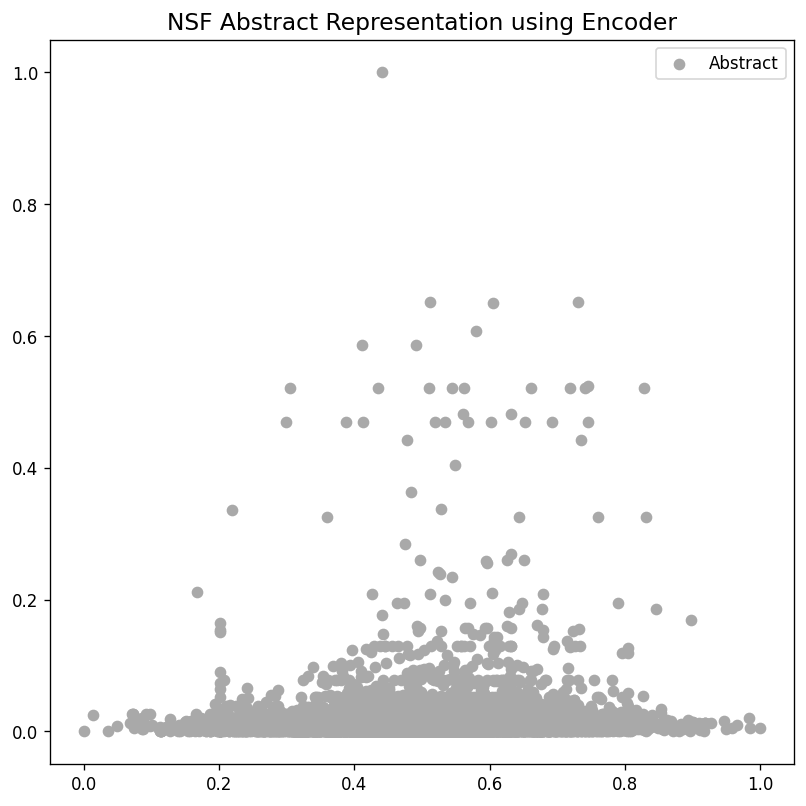

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


f,ax=plt.subplots(figsize=(8,8),dpi=120)
ax.scatter(scores['dim_1'],scores["amount"],color='darkgray',label='Abstract')
ax.set_title("NSF Abstract Representation using Encoder",size=14)
ax.legend();
#f.savefig('encoder.png',dpi=200)
f.show()


In [38]:
##Cluster Algorithm
##lets use Gaussian Mixed Models to find which suits our data best based on the Silhouette index
##


from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as GMM

def test_clustering_gmm(data):
  #epsilons=np.round(np.linspace(0.1,1),2)

  ncomp=range(2,15,1)
  values=[]
  gmm_best=0
  best_sl=0
  for i in ncomp:
    gmm=GMM(n_components=i,covariance_type='full',init_params='kmeans').fit(data) 
    labs=gmm.predict(data)
    

    if (len(set(labs))>1):
        
        sl=silhouette_score(data,labs)
        if(sl>best_sl):
          best_sl=sl
          gmm_best=gmm
        values.append((sl,i))
        print("[INFO] USING {} components : Silhouette Score={:.2f}".format(i,sl))
  return gmm_best

clusters=test_clustering_gmm(scores.iloc[:,:]) 


[INFO] USING 2 components : Silhouette Score=0.56
[INFO] USING 3 components : Silhouette Score=0.28
[INFO] USING 4 components : Silhouette Score=0.33
[INFO] USING 5 components : Silhouette Score=0.05
[INFO] USING 6 components : Silhouette Score=0.04
[INFO] USING 7 components : Silhouette Score=0.03
[INFO] USING 8 components : Silhouette Score=0.02
[INFO] USING 9 components : Silhouette Score=0.01
[INFO] USING 10 components : Silhouette Score=0.01
[INFO] USING 11 components : Silhouette Score=0.01
[INFO] USING 12 components : Silhouette Score=0.01
[INFO] USING 13 components : Silhouette Score=-0.01
[INFO] USING 14 components : Silhouette Score=-0.01


In [39]:
##lets use the best combination of parameters in the previous section to fit the final clustering algorithm
best_dbs=clusters.predict(scores)

### 

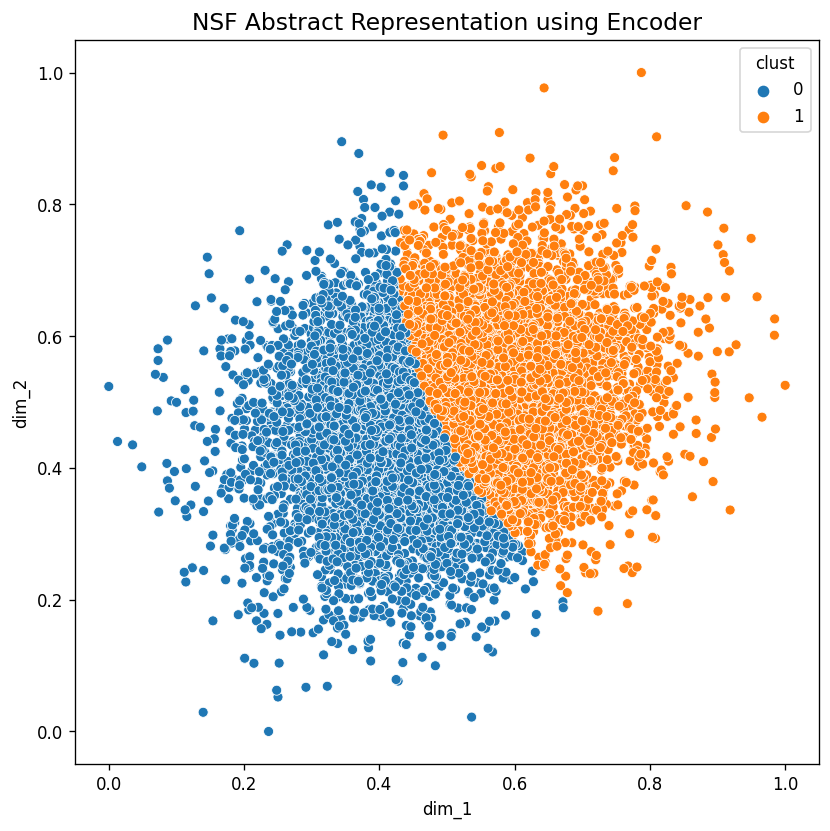

In [44]:
###use the clustering to see how every paper is grouped (at least in two dimensions)
scores['clust']=best_dbs


import seaborn as sns


f,ax=plt.subplots(figsize=(8,8),dpi=120)

sns.scatterplot(x='dim_1',y='dim_2',hue='clust',data=scores,ax=ax)
ax.set_title("NSF Abstract Representation using Encoder",size=14)
f.show()


### 5. Conclusions

We've used every paper abstract, title, additional descriptions and award amount to find a way to group them. One thing to consider for further work should be more text cleanning and stemming. Also, more data could be useful for the encoder to generate meaningful dimensions.